In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm

In [46]:
# 2) 딥러닝 모델 만들기
# MLP Multi-layer Perceptron
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        
        # 해당 모델의 디자인을 작성하는 곳
        self.fc1 = nn.Linear(784, 512) # -> nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)        

    def forward(self, x):
        # check is 1d
        x = x.view(-1, 28 * 28) # flatten, x -> [256 (batch) x 28 (width) x 28 (height)] -> [256, 784]
        x = self.fc1(x)     # [256 x 784] * [784 x 512] -> [256 x 512]
        x = F.relu(x)       # Activation Function (활성화 함수)
        x = self.dropout1(x)    # 인공지능 모델이 너무 좋아요 -> overfitting 발생
        x = self.fc2(x)     # [1 x 512] * [512 x 256] -> [1 x 256]
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)     # [1 x 256] * [256 x 10] -> [1 x 10]
        x = F.log_softmax(x, dim=1) # [1 x 10] -> [1 x 10] 0-1 사이의 값을 갖는 확률로 표현되어있음
        return x

In [52]:
# 1) 데이터를 준비
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainSet = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainSet, batch_size=256)

# 2) 학습 준비
# 학습에 필요한 요소 [Epoch/Optimizer]
    # Epoch -> 인공지능 모델은 데이터셋을 무수히 많이 반복학습하게 됩니다.
    # 자기 스스로 데이터의 숨겨진 패턴을 알아서 찾아내요 -> 행렬 곱 연산으로
        
epochs = 10 # 얼마나 인공지능 모델을 학습할 것인지 > 엔지니어가 임의로 정해주는 부분 [Hyper-parameter]
model = MLP()
optimizer = optim.Adam(model.parameters(), lr=0.001)
    # optimizer: 인공지능 모델을 수정해주는 역할 -> Gradient Descent
    # Model의 [parameter, weights, 행렬, 인공지능모델]
    # learning rate (lr): Optimizer가 모델을 수정하는 속도 [Hyper-parameter]

# 학습을 시작
for epoch in range(epochs):
    model.train()   # 너 학습하는 중이야

    for iter_idx, (data, target) in enumerate(train_loader):
        # data >> [256 x [1 x 28 x 28]]
        # target >> [256 (0-9)]
        
        optimizer.zero_grad()   # 데이터를 모델에 넣어주기전에 optimizer.zero_grad() 꼭해줘야합니다.
        output = model(data)    # 실제로 데이터를 모델에 넣어주는 부분
        loss = F.nll_loss(output, target)   # Loss 손실함수 계산 -> 인공지능 모델이 얼마나 못했는지 알려주는 부분
        loss.backward()     # 얼마나 못했는지 알았으면, 인공지능 모델의 '어떤'부분에서 이렇게 못하게 만들었는지
        optimizer.step()    # 실제로 인공지능 모델의 행렬을 바꾸는 역할

        if iter_idx % 100 == 0:
            print(f'Epoch: [{epoch}/{epochs}], Iterations: [{iter_idx+1}/{len(train_loader)}], Running Loss: [{loss.item():.5}]')
    
    torch.save(model.state_dict(), "model.pt")  # 모델 저장 torch.save(내가 저장할 모델, "저장할 이름")

Epoch: [0/10], Iterations: [1/235], Running Loss: [2.3047]
Epoch: [0/10], Iterations: [101/235], Running Loss: [0.30242]
Epoch: [0/10], Iterations: [201/235], Running Loss: [0.18379]
Epoch: [1/10], Iterations: [1/235], Running Loss: [0.18747]
Epoch: [1/10], Iterations: [101/235], Running Loss: [0.17213]


KeyboardInterrupt: 

In [ ]:
# validation vs. evaluation
# validation (검증) -> 인공지능 모델이 학습되는 와중에, 잘 학습된 구간을 골라내기위해 '검증'한다
# evaluation (평가) -> 학습이 끝난 모델을, 평가한다

In [9]:
def val(model, loader):
    model.eval()
    corr = 0
    for data, target in loader:
        
        output = model(data)
        loss = F.nll_loss(output, target)

        pred = output.argmax(1)
        corr += (pred == target).sum()
    score = (corr / len(loader.dataset)).cpu().item()
    return score

# Generate Validation Set
dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
trainSet, validSet = torch.utils.data.random_split(dataset, [50000, 10000])
train_loader = torch.utils.data.DataLoader(trainSet, batch_size=256)
valid_loader = torch.utils.data.DataLoader(validSet, batch_size=256)

best_score = 0
epochs = 10
optimizer = optim.Adam(model.parameters(), lr=0.001)
for epoch in range(epochs):
    train_one_epoch(model, train_loader, optimizer, epoch, epochs)
    
    with torch.no_grad():
        curr_score = val(model, valid_loader)
    print(f'curr_score: {curr_score}')
    
    if curr_score > best_score:
        print(f'Best Score is updated: {best_score} -> {curr_score}')
        torch.save(model.state_dict(), "best.pt")
        best_score = curr_score

Epoch: [0/10], Iterations: [1/196], Running Loss: [2.8277]
curr_score: 0.6606000065803528
Best Score is updated: 0 -> 0.6606000065803528
Epoch: [1/10], Iterations: [1/196], Running Loss: [1.4285]
curr_score: 0.6935999989509583
Best Score is updated: 0.6606000065803528 -> 0.6935999989509583
Epoch: [2/10], Iterations: [1/196], Running Loss: [1.2067]
curr_score: 0.6872000098228455
Epoch: [3/10], Iterations: [1/196], Running Loss: [1.2104]
curr_score: 0.6873999834060669
Epoch: [4/10], Iterations: [1/196], Running Loss: [1.0788]
curr_score: 0.7167999744415283
Best Score is updated: 0.6935999989509583 -> 0.7167999744415283
Epoch: [5/10], Iterations: [1/196], Running Loss: [1.0486]
curr_score: 0.7591999769210815
Best Score is updated: 0.7167999744415283 -> 0.7591999769210815
Epoch: [6/10], Iterations: [1/196], Running Loss: [0.87325]
curr_score: 0.8026999831199646
Best Score is updated: 0.7591999769210815 -> 0.8026999831199646
Epoch: [7/10], Iterations: [1/196], Running Loss: [0.76405]
curr_s

#### 테스트

In [99]:
def test(model, loader):
    model.eval()
    corr = 0
    for data, target in loader:
        
        output = model(data)
        loss = F.nll_loss(output, target)

        pred = output.argmax(1)
        corr += (pred == target).sum()
    score = (corr / len(loader.dataset)).cpu().item()
    return score

# 1. 데이터 준비 (테스트셋 준비)
# Generate Validation Set
testSet = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testSet, batch_size=256)

# 2. 모델 준비 (설계해서, 학습이 끝난 모델)
model = MLP()
model.load_state_dict( torch.load('model.pt') )

# 3. 평가를 진행한다
model.eval()    # 너 평가되는거야
with torch.no_grad():   # 너 평가되는거니까, 학습에 사용되는거는 쓰지마
    
    corr = 0    # correct
    running_loss = []
    for data, target in test_loader:
        
        output = model(data)    # 확률로 변환되기 전의 값 -> Logits -> 가장 큰 값을 갖는 것을 선택
                                # 전통적인 방식은 -> Logits -> Probabilty -> 가장 큰 확률값을 갖는 것을 선택

        pred = output.argmax(1) # Prediction
        corr += (pred == target).sum()
        
        loss = F.nll_loss(output, target)
        running_loss.append(loss)
        
score = (corr / len(testSet)).cpu().item()  # 정확도를 측정

In [106]:
import matplotlib.pyplot as plt

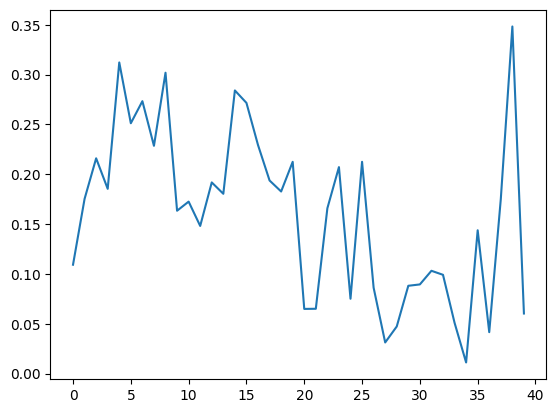

In [107]:
plt.plot(running_loss)

In [ ]:
Pytorch -> 기업/연구실에서 빠르고, 정확하고, 편하고, 보안성 떨어지지만, 하는사람도많고, 연구공유 를 할때 좋아요
- 연구개발용

- 모든 기업/연구실 Pytorch 연구개발 (95%)
- 테슬라 포함

In [ ]:
Tensorflow -> 기업/연구실에서 빠르고, 정확한대신, 엄청나게 불편하고, 보안성이 높게 사용할 때 좋아요
- 제품개발용
- Pytorch Model -> Tensorflow

- 국가보안연구소/NASA 등등 정부기관들
- 대기업에서 한화 테크/ 한화 방위산업류
- 이상탐지